In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
data = np.load('board_grade.npy', allow_pickle=True)

In [3]:
x, y = data[:, 1], data[:, 0]

In [4]:
for i in range(y.shape[0]):
    try:
        assert y[i].shape == y[i+1].shape
    except:
        if i + 1 < y.shape[0]:
            print(y[i+1])

In [5]:
all_boards = np.stack(x).reshape(-1, 18, 11, 2)
all_classes = np.stack(y).reshape(-1, 7)

In [6]:
train_boards, train_classes, valid_boards, valid_classes = train_test_split(all_boards, all_classes, test_size=0.2)

In [7]:
train_boards.shape

(15855, 18, 11, 2)

In [8]:
grade_to_list = {
    "V4 (6B+)": tuple([0,0,0,0,0,0,0]),
    "V5 (6C/+)": tuple([1,0,0,0,0,0,0]),
    "V6 (7A)": tuple([1,1,0,0,0,0,0]),
    "V7 (7A+)": tuple([1,1,1,0,0,0,0]),
    "V8 (7B/+)": tuple([1,1,1,1,0,0,0]),
    "V9 (7C)": tuple([1,1,1,1,1,0,0]),
    "V10 (7C+)": tuple([1,1,1,1,1,1,0]),
    "V11 (8A) or harder": tuple([1,1,1,1,1,1,1]),
}

grade_num_to_list = {
    0: tuple([0,0,0,0,0,0,0]),
    1: tuple([1,0,0,0,0,0,0]),
    2: tuple([1,1,0,0,0,0,0]),
    3: tuple([1,1,1,0,0,0,0]),
    4: tuple([1,1,1,1,0,0,0]),
    5: tuple([1,1,1,1,1,0,0]),
    6: tuple([1,1,1,1,1,1,0]),
    7: tuple([1,1,1,1,1,1,1]),
}

print_dict = {
    0: "M",
    1: "S",
    2: "E"
}

list_to_grade = dict((v,k) for k,v in grade_to_list.items())
list_to_grade_num = dict((v,k) for k,v in grade_num_to_list.items())

def print_board_bar():
    for i in range(26):
        print("-", end="")
    print()

def print_board(board, grade_list):
    print(" "*3, end="| ")
    for i in range(11):
        print(f"{chr(i + 65)}", end=" ")
    print()
    print_board_bar()
    for i in range(18):
        print(f"{18 - i:2} |", end=" ")
        for j in range(11):
            num_printed = False
            if board[17 - i, j, 0] > 0:
                char = "M"
                if board[17 - i, j, 1] > 0:
                    char = "S" if i >= 12 else "E"
                print(char, end=" ")  
                num_printed = True
            if not num_printed:
                print("-", end=" ")
        print()
    print_board_bar()
        
    print(f"Problem Grade: {list_to_grade[tuple([round(x) for x in grade_list])]}")

def print_problem(problem_num):
    if problem_num < 0 or problem_num > all_boards.shape[0]:
        print("problem number out of bounds!")
        return -1
    print_board(all_boards[problem_num], all_classes[problem_num])

print_problem(1)
print()
print()
print_problem(5)
print()
print()
print_problem(10)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - E - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - M - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - M - M 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - M - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)


   | A B C D E F G H I J K 
--------------------------
18 | - - E - - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - M - - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - M - - - - - - - 
12 | - - - - - - - - M - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - M - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [10]:
# Convert data to PyTorch tensors
x_tensor = torch.tensor(all_boards, dtype=torch.float32)
y_tensor = torch.tensor(all_classes, dtype=torch.float32)
# create the dataset
dataset = data.TensorDataset(x_tensor, y_tensor)
val_size = int(len(dataset)*0.2)
train_size = len(dataset)- int(len(dataset)*0.2)

# do stratified random sampling
# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(dataset)),
    y_tensor,
    stratify=y_tensor,
    test_size=val_size,
    random_state=42
)

# generate subset based on indices
train_dataset = data.Subset(dataset, train_indices)
val_dataset = data.Subset(dataset, val_indices)


#train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

In [11]:
# create an oversampler
# Define a function to calculate class weights
def calculate_class_weights(dataset, num_classes):
    class_counts = [0] * num_classes

    # Count occurrences of each class in the dataset
    for sample in dataset:
        label = max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])])
        class_counts[label] += 1

    # Calculate normalized class weights
    class_weights = [1 / (count) for count in class_counts]
    weights_total = sum(class_weights)
    class_weights_normalized = [weight / weights_total for weight in class_weights]

    return class_weights_normalized

# Calculate sample weights from class weights
class_weights = calculate_class_weights(train_dataset, 8)
labels = [max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])]) for sample in train_dataset]
sample_weights = [class_weights[label] for label in labels]

# Create upsampler using sample weights
train_sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

print("Class weights:", class_weights)

Class weights: [0.010582424411955484, 0.015532026781826275, 0.03399583376073786, 0.05911921225297821, 0.044299678536337844, 0.18310533795019643, 0.19560214143047688, 0.45776334487549103]


In [12]:
INPUT_DIM = 18 * 11 * 2
OUTPUT_DIM = 7

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# calculate the number of exactly correct predictions
def calculate_accuracy(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (torch.sum(thresh_y[i]) == torch.sum(thresh_pred[i]))
    acc = correct.float() / y.shape[0]
    return acc

# calculate the number of correct predictions within one class
def calculate_plus_minus_one(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (torch.abs(torch.sum(thresh_y[i]) - torch.sum(thresh_pred[i])) <= 1)
    acc = correct.float() / y.shape[0]
    return acc

In [13]:
# custom weight sharing final layer for ordinal regression, in the style of CORAL (1 weight, K - 1 bias)
# doing it this way, along with the way classes are set up (a binary classification with K - 1 classes) assures rank constisency and improves performance
# for the small MLP. however, it limits the predictive power of the deeper model, so instead the deeper model relies on label smoothing and 
# other regularization methods and learns the ordinal ranking itself
class CoralLayer(torch.nn.Module):
    def __init__(self, size_in, num_classes):
        super().__init__()
        self.size_in, self.size_out = size_in, 1
        self.coral_weight = torch.nn.Linear(self.size_in, 1, bias=False)
        self.coral_bias = torch.nn.Parameter(torch.arange(num_classes, 0, -1).float() / (num_classes))

    def forward(self, x):
        return self.coral_weight(x) + self.coral_bias

In [14]:
# a small MLP, to get a baseline for likely performance
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 64)
        self.hidden_fc = nn.Linear(64, 32)
        self.hidden_fc2 = nn.Linear(32, 16)
        self.output_fc = CoralLayer(16, output_dim)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = self.dropout(F.mish(self.input_fc(x)))
        h_2 = self.dropout(F.mish(self.hidden_fc(h_1)))
        h_3 = self.dropout(F.mish(self.hidden_fc2(h_2)))
        y_pred = self.output_fc(h_3)
        return y_pred, h_3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# A CNN, where we use regularization and a small effective model to exploit spatial properties in the data
class CNN(nn.Module):
    def __init__(self, input_channels, input_size, output_dim):
        super().__init__()

        self.input_conv2d = nn.Conv2d(input_channels, 16, 11, padding=5)
        self.pool = nn.AdaptiveMaxPool2d(11)
        self.flatten = nn.Flatten()
        self.hidden_fc = nn.Linear(16 * 11 * 11, 64)
        self.hidden_fc2 = nn.Linear(64, 16)
        self.output_fc = CoralLayer(16, output_dim)

        self.dropoutConv = nn.Dropout2d(0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        batch_size = x.shape[0]
        # use BCHW form instead of BHWC form for Conv layers
        x = x.permute(0, 3, 1, 2)
        c_1 = self.dropoutConv(F.mish(self.input_conv2d(x)))
        h_pool = self.flatten(self.pool(c_1))
        h_1 = self.dropout(F.mish(self.hidden_fc(h_pool)))
        h_2 = F.mish(self.hidden_fc2(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = 2

In [16]:
# a deeper residual CNN (ResNet style), where we use a deep network with skip connections to build a more abstract feature set and gain predictive power
class ResidualBlock(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size, kernel_size, use_pooling = True):
        super().__init__()
        conv_pad = (kernel_size) // 2 # calculate the proper padding for a given kernel size
        self.conv1 = nn.Conv2d(in_size, hidden_size, kernel_size, padding=conv_pad)
        self.conv2 = nn.Conv2d(hidden_size, out_size, kernel_size, padding=conv_pad)
        self.maxpool = nn.MaxPool2d(kernel_size, stride=1, padding=conv_pad)
        
        self.dropoutConv = nn.Dropout2d(0.5)
        self.use_pooling = use_pooling
    
    def ConvBlock(self, x):
        c_1 = self.dropoutConv(F.mish(self.conv1(x)))
        c_2 = self.dropoutConv(F.mish(self.conv2(c_1)))
        if self.use_pooling:
            d_1 = self.maxpool(c_2)
            return d_1
        return c_2
    
    def forward(self, x):
        return x + self.ConvBlock(x)


class ResNet(nn.Module):
    
    def __init__(self, input_channels, input_size, output_dim):
        super().__init__()
        self.input_conv2d = nn.Conv2d(input_channels, 16, 11, padding=5)
        self.res_block1 = ResidualBlock(16, 32, 16, 9, False)
        self.res_block2 = ResidualBlock(16, 32, 16, 7, True) # after our first two blocks we add a pooling layer
        self.res_block3 = ResidualBlock(16, 32, 16, 3, False)
        self.pool = nn.AdaptiveMaxPool2d(11)
        self.flatten = nn.Flatten()
        self.hidden_fc = nn.Linear(16 * 11 * 11, 32)
        # we don't use a CORAL layer in the ResNet, as this may limit the predictive power of the deep model
        # something to look into for an extension to this is a CORN style loss, so the weight sharing constraint is no longer imposed
        self.output_fc = nn.Linear(32, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        # use BCHW form instead of BHWC form for Conv layers
        x = x.permute(0, 3, 1, 2)
        # input
        conv = F.mish(self.input_conv2d(x))
        # resnet blocks
        b_1 = self.res_block1(conv)
        b_2 = self.res_block2(b_1)
        b_3 = self.res_block3(b_2)
        h_pool = self.flatten(self.pool(b_3))
        # fully connected
        h_1 = F.mish(self.hidden_fc(h_pool))
        y_pred = self.output_fc(h_1)
        return y_pred, h_1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = 2

In [17]:
import time
from tqdm import tqdm

# fix the random seed; don't modify this
torch.manual_seed(23459078)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(INPUT_DIM, OUTPUT_DIM)
BATCH_SIZE = 8

train_iterator = data.DataLoader(train_dataset,
                                 #shuffle=True,
                                 sampler=train_sampler,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_dataset,
                                 batch_size=BATCH_SIZE)

# Loss and optimizer
avg_class_difficulty = torch.tensor([1, 1, 1.1, 1.2, 1.1, 1.2, 2]) # these weights correspond to the relative avg class difficulty (to classify)
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model = model.to(device)
criterion = criterion.to(device)

# label smoothing, since our dataset is somewhat noisy (due to the subjectiveness of grades and the culture of the moonboard)
# this should improve the generalization of our models
def label_smoothing(labels, eps = 0.01):
    return labels * (1 - eps) + (eps / 2)

def train(model, iterator, optimizer, criterion, device, smooth_labels):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)

        # label smoothing
        if smooth_labels:
            smoothed_labels = label_smoothing(y)
            loss = criterion(y_pred, smoothed_labels)
        else:
            loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        plus_minus = calculate_plus_minus_one(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            plus_minus = calculate_plus_minus_one(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)


def full_train_valid_loop(model, checkpoint_name, train_iterator, valid_iterator, criterion, device, label_smoothing = False, epochs = 50):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {total_params:,}")
    
    best_valid_loss = float('inf')
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(epochs):      
        start_time = time.monotonic()
        train_loss, train_acc, train_plus_minus = train(model, train_iterator, optimizer, criterion, device, label_smoothing)
        valid_loss, valid_acc, valid_plus_minus = evaluate(model, valid_iterator, criterion, device)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        if valid_loss < best_valid_loss: # save best model weights
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{checkpoint_name}.pt')
    
        end_time = time.monotonic()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc*100:6.2f}% | Train Acc +/- 1 Grade: {train_plus_minus*100:6.2f}%')
        print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc*100:6.2f}% |  Val. Acc +/- 1 Grade: {valid_plus_minus*100:6.2f}%')

    return train_loss_list, valid_loss_list

# we don't use label smoothing on our MLP
train_loss_list, valid_loss_list = full_train_valid_loop(model, 'mlp', train_iterator, valid_iterator, criterion, device)

Number of trainable parameters: 28,039


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.05578 | Train Acc:  29.59% | Train Acc +/- 1 Grade:  62.97%
	 Val. Loss: 0.03630 |  Val. Acc:  48.39% |  Val. Acc +/- 1 Grade:  81.49%


Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.04531 | Train Acc:  33.21% | Train Acc +/- 1 Grade:  73.01%
	 Val. Loss: 0.03390 |  Val. Acc:  46.14% |  Val. Acc +/- 1 Grade:  81.64%


Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.04318 | Train Acc:  34.04% | Train Acc +/- 1 Grade:  75.83%
	 Val. Loss: 0.03034 |  Val. Acc:  50.48% |  Val. Acc +/- 1 Grade:  85.26%


Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.04286 | Train Acc:  33.82% | Train Acc +/- 1 Grade:  76.10%
	 Val. Loss: 0.02942 |  Val. Acc:  50.78% |  Val. Acc +/- 1 Grade:  86.69%


Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.04065 | Train Acc:  36.23% | Train Acc +/- 1 Grade:  77.95%
	 Val. Loss: 0.02787 |  Val. Acc:  52.22% |  Val. Acc +/- 1 Grade:  87.91%


Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.03982 | Train Acc:  36.70% | Train Acc +/- 1 Grade:  79.28%
	 Val. Loss: 0.02996 |  Val. Acc:  45.99% |  Val. Acc +/- 1 Grade:  87.02%


Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.03842 | Train Acc:  38.17% | Train Acc +/- 1 Grade:  80.85%
	 Val. Loss: 0.02808 |  Val. Acc:  49.82% |  Val. Acc +/- 1 Grade:  87.58%


Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.03789 | Train Acc:  38.22% | Train Acc +/- 1 Grade:  80.50%
	 Val. Loss: 0.02694 |  Val. Acc:  50.45% |  Val. Acc +/- 1 Grade:  88.49%


Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.03816 | Train Acc:  38.02% | Train Acc +/- 1 Grade:  81.05%
	 Val. Loss: 0.02577 |  Val. Acc:  52.47% |  Val. Acc +/- 1 Grade:  89.45%


Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.03641 | Train Acc:  39.87% | Train Acc +/- 1 Grade:  82.61%
	 Val. Loss: 0.02603 |  Val. Acc:  52.34% |  Val. Acc +/- 1 Grade:  89.47%


Epoch: 11 | Epoch Time: 0m 6s
	Train Loss: 0.03656 | Train Acc:  39.25% | Train Acc +/- 1 Grade:  82.76%
	 Val. Loss: 0.02465 |  Val. Acc:  54.98% |  Val. Acc +/- 1 Grade:  90.13%


Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.03523 | Train Acc:  40.89% | Train Acc +/- 1 Grade:  83.22%
	 Val. Loss: 0.02496 |  Val. Acc:  53.76% |  Val. Acc +/- 1 Grade:  90.38%


Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.03551 | Train Acc:  40.99% | Train Acc +/- 1 Grade:  83.38%
	 Val. Loss: 0.02564 |  Val. Acc:  52.95% |  Val. Acc +/- 1 Grade:  89.17%


Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.03500 | Train Acc:  41.33% | Train Acc +/- 1 Grade:  84.16%
	 Val. Loss: 0.02521 |  Val. Acc:  52.54% |  Val. Acc +/- 1 Grade:  89.83%


Epoch: 15 | Epoch Time: 0m 5s
	Train Loss: 0.03429 | Train Acc:  41.36% | Train Acc +/- 1 Grade:  84.38%
	 Val. Loss: 0.02504 |  Val. Acc:  53.39% |  Val. Acc +/- 1 Grade:  89.42%


Epoch: 16 | Epoch Time: 0m 5s
	Train Loss: 0.03380 | Train Acc:  42.35% | Train Acc +/- 1 Grade:  84.21%
	 Val. Loss: 0.02609 |  Val. Acc:  51.00% |  Val. Acc +/- 1 Grade:  88.77%


Epoch: 17 | Epoch Time: 0m 5s
	Train Loss: 0.03337 | Train Acc:  42.46% | Train Acc +/- 1 Grade:  85.08%
	 Val. Loss: 0.02503 |  Val. Acc:  53.76% |  Val. Acc +/- 1 Grade:  89.63%


Epoch: 18 | Epoch Time: 0m 5s
	Train Loss: 0.03307 | Train Acc:  43.01% | Train Acc +/- 1 Grade:  85.36%
	 Val. Loss: 0.02458 |  Val. Acc:  53.22% |  Val. Acc +/- 1 Grade:  90.28%


Epoch: 19 | Epoch Time: 0m 5s
	Train Loss: 0.03306 | Train Acc:  42.78% | Train Acc +/- 1 Grade:  85.41%
	 Val. Loss: 0.02444 |  Val. Acc:  54.15% |  Val. Acc +/- 1 Grade:  90.26%


Epoch: 20 | Epoch Time: 0m 5s
	Train Loss: 0.03258 | Train Acc:  43.25% | Train Acc +/- 1 Grade:  85.43%
	 Val. Loss: 0.02485 |  Val. Acc:  53.49% |  Val. Acc +/- 1 Grade:  90.48%


Epoch: 21 | Epoch Time: 0m 5s
	Train Loss: 0.03220 | Train Acc:  43.86% | Train Acc +/- 1 Grade:  85.88%
	 Val. Loss: 0.02452 |  Val. Acc:  53.72% |  Val. Acc +/- 1 Grade:  90.36%


Epoch: 22 | Epoch Time: 0m 5s
	Train Loss: 0.03206 | Train Acc:  43.89% | Train Acc +/- 1 Grade:  86.12%
	 Val. Loss: 0.02514 |  Val. Acc:  53.02% |  Val. Acc +/- 1 Grade:  89.88%


Epoch: 23 | Epoch Time: 0m 5s
	Train Loss: 0.03207 | Train Acc:  44.01% | Train Acc +/- 1 Grade:  86.27%
	 Val. Loss: 0.02436 |  Val. Acc:  54.51% |  Val. Acc +/- 1 Grade:  91.13%


Epoch: 24 | Epoch Time: 0m 5s
	Train Loss: 0.03193 | Train Acc:  43.50% | Train Acc +/- 1 Grade:  86.30%
	 Val. Loss: 0.02460 |  Val. Acc:  53.87% |  Val. Acc +/- 1 Grade:  90.45%


Epoch: 25 | Epoch Time: 0m 5s
	Train Loss: 0.03155 | Train Acc:  44.75% | Train Acc +/- 1 Grade:  86.47%
	 Val. Loss: 0.02456 |  Val. Acc:  52.71% |  Val. Acc +/- 1 Grade:  90.55%


Epoch: 26 | Epoch Time: 0m 5s
	Train Loss: 0.03169 | Train Acc:  43.78% | Train Acc +/- 1 Grade:  86.63%
	 Val. Loss: 0.02422 |  Val. Acc:  53.92% |  Val. Acc +/- 1 Grade:  90.58%


Epoch: 27 | Epoch Time: 0m 5s
	Train Loss: 0.03113 | Train Acc:  44.19% | Train Acc +/- 1 Grade:  87.08%
	 Val. Loss: 0.02473 |  Val. Acc:  53.02% |  Val. Acc +/- 1 Grade:  90.66%


Epoch: 28 | Epoch Time: 0m 5s
	Train Loss: 0.03136 | Train Acc:  44.84% | Train Acc +/- 1 Grade:  87.03%
	 Val. Loss: 0.02411 |  Val. Acc:  54.91% |  Val. Acc +/- 1 Grade:  90.31%


Epoch: 29 | Epoch Time: 0m 5s
	Train Loss: 0.03079 | Train Acc:  44.99% | Train Acc +/- 1 Grade:  87.27%
	 Val. Loss: 0.02501 |  Val. Acc:  52.84% |  Val. Acc +/- 1 Grade:  89.77%


Epoch: 30 | Epoch Time: 0m 5s
	Train Loss: 0.03052 | Train Acc:  44.71% | Train Acc +/- 1 Grade:  87.64%
	 Val. Loss: 0.02362 |  Val. Acc:  56.47% |  Val. Acc +/- 1 Grade:  91.06%


Epoch: 31 | Epoch Time: 0m 6s
	Train Loss: 0.03067 | Train Acc:  45.53% | Train Acc +/- 1 Grade:  87.52%
	 Val. Loss: 0.02384 |  Val. Acc:  54.86% |  Val. Acc +/- 1 Grade:  90.83%


Epoch: 32 | Epoch Time: 0m 5s
	Train Loss: 0.03077 | Train Acc:  45.20% | Train Acc +/- 1 Grade:  86.76%
	 Val. Loss: 0.02369 |  Val. Acc:  55.11% |  Val. Acc +/- 1 Grade:  90.57%


Epoch: 33 | Epoch Time: 0m 5s
	Train Loss: 0.03064 | Train Acc:  45.57% | Train Acc +/- 1 Grade:  87.39%
	 Val. Loss: 0.02479 |  Val. Acc:  52.66% |  Val. Acc +/- 1 Grade:  90.22%


Epoch: 34 | Epoch Time: 0m 5s
	Train Loss: 0.03039 | Train Acc:  45.72% | Train Acc +/- 1 Grade:  87.53%
	 Val. Loss: 0.02398 |  Val. Acc:  54.23% |  Val. Acc +/- 1 Grade:  91.10%


Epoch: 35 | Epoch Time: 0m 5s
	Train Loss: 0.03014 | Train Acc:  44.90% | Train Acc +/- 1 Grade:  87.78%
	 Val. Loss: 0.02470 |  Val. Acc:  52.21% |  Val. Acc +/- 1 Grade:  91.36%


Epoch: 36 | Epoch Time: 0m 5s
	Train Loss: 0.02994 | Train Acc:  45.89% | Train Acc +/- 1 Grade:  88.31%
	 Val. Loss: 0.02342 |  Val. Acc:  55.59% |  Val. Acc +/- 1 Grade:  91.56%


Epoch: 37 | Epoch Time: 0m 5s
	Train Loss: 0.03039 | Train Acc:  45.68% | Train Acc +/- 1 Grade:  87.53%
	 Val. Loss: 0.02411 |  Val. Acc:  53.92% |  Val. Acc +/- 1 Grade:  90.95%


Epoch: 38 | Epoch Time: 0m 5s
	Train Loss: 0.02986 | Train Acc:  46.69% | Train Acc +/- 1 Grade:  88.37%
	 Val. Loss: 0.02566 |  Val. Acc:  51.15% |  Val. Acc +/- 1 Grade:  89.52%


Epoch: 39 | Epoch Time: 0m 5s
	Train Loss: 0.02990 | Train Acc:  46.42% | Train Acc +/- 1 Grade:  88.11%
	 Val. Loss: 0.02374 |  Val. Acc:  54.88% |  Val. Acc +/- 1 Grade:  91.08%


Epoch: 40 | Epoch Time: 0m 5s
	Train Loss: 0.02970 | Train Acc:  46.25% | Train Acc +/- 1 Grade:  88.14%
	 Val. Loss: 0.02646 |  Val. Acc:  48.55% |  Val. Acc +/- 1 Grade:  89.84%


Epoch: 41 | Epoch Time: 0m 5s
	Train Loss: 0.02971 | Train Acc:  46.28% | Train Acc +/- 1 Grade:  88.07%
	 Val. Loss: 0.02390 |  Val. Acc:  53.77% |  Val. Acc +/- 1 Grade:  91.43%


Epoch: 42 | Epoch Time: 0m 5s
	Train Loss: 0.02986 | Train Acc:  46.88% | Train Acc +/- 1 Grade:  88.21%
	 Val. Loss: 0.02401 |  Val. Acc:  54.38% |  Val. Acc +/- 1 Grade:  91.18%


Epoch: 43 | Epoch Time: 0m 6s
	Train Loss: 0.02941 | Train Acc:  47.09% | Train Acc +/- 1 Grade:  88.14%
	 Val. Loss: 0.02362 |  Val. Acc:  55.38% |  Val. Acc +/- 1 Grade:  91.44%


Epoch: 44 | Epoch Time: 0m 5s
	Train Loss: 0.02920 | Train Acc:  47.04% | Train Acc +/- 1 Grade:  88.53%
	 Val. Loss: 0.02364 |  Val. Acc:  54.75% |  Val. Acc +/- 1 Grade:  90.68%


Epoch: 45 | Epoch Time: 0m 6s
	Train Loss: 0.02959 | Train Acc:  46.61% | Train Acc +/- 1 Grade:  88.26%
	 Val. Loss: 0.02467 |  Val. Acc:  52.68% |  Val. Acc +/- 1 Grade:  91.14%


Epoch: 46 | Epoch Time: 0m 5s
	Train Loss: 0.02915 | Train Acc:  46.71% | Train Acc +/- 1 Grade:  88.62%
	 Val. Loss: 0.02438 |  Val. Acc:  54.25% |  Val. Acc +/- 1 Grade:  90.61%


Epoch: 47 | Epoch Time: 0m 5s
	Train Loss: 0.02963 | Train Acc:  46.19% | Train Acc +/- 1 Grade:  88.31%
	 Val. Loss: 0.02392 |  Val. Acc:  55.66% |  Val. Acc +/- 1 Grade:  90.94%


Epoch: 48 | Epoch Time: 0m 5s
	Train Loss: 0.02911 | Train Acc:  47.02% | Train Acc +/- 1 Grade:  88.84%
	 Val. Loss: 0.02435 |  Val. Acc:  53.39% |  Val. Acc +/- 1 Grade:  90.93%


Epoch: 49 | Epoch Time: 0m 6s
	Train Loss: 0.02879 | Train Acc:  47.44% | Train Acc +/- 1 Grade:  88.94%
	 Val. Loss: 0.02435 |  Val. Acc:  55.89% |  Val. Acc +/- 1 Grade:  91.47%


Epoch: 50 | Epoch Time: 0m 5s
	Train Loss: 0.02916 | Train Acc:  47.40% | Train Acc +/- 1 Grade:  88.45%
	 Val. Loss: 0.02422 |  Val. Acc:  54.43% |  Val. Acc +/- 1 Grade:  91.29%


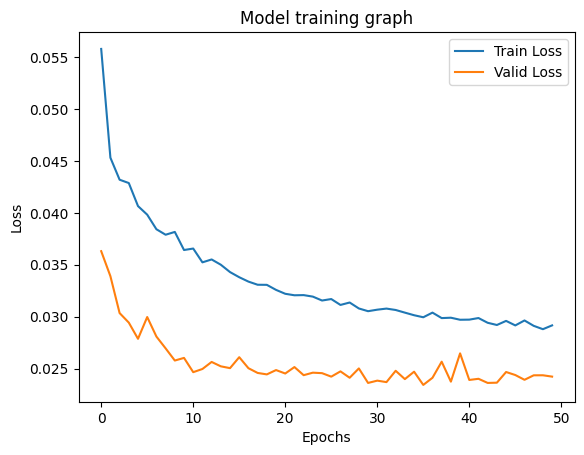

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the training graph
def plot_train_graph(train_loss_list, valid_loss_list):
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(valid_loss_list, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model training graph')
    plt.legend()
    plt.show()

plot_train_graph(train_loss_list, valid_loss_list)

In [19]:
import math

# get the best performing model weights
model.load_state_dict(torch.load('mlp.pt'))

def show_boulder(model, device, dataset):
    # grab a boulder from the validation set and see what the net thinks
    view_iterator = data.DataLoader(dataset,
                                     shuffle=True,
                                     batch_size=1)
    
    # set it up properly for viewing + prediction
    board, grade = next(iter(view_iterator))
    view_board = board.reshape(18, 11, 2)
    view_grade = grade.reshape(7)
    board = board.to(device)
    grade = grade.to(device)
    print_board(view_board, view_grade.numpy())
    pred = model.eval()(board)[0].cpu()
    pred_numpy = pred.detach().numpy().reshape(7)
    pred_sig_numpy = torch.sigmoid(pred).detach().numpy().reshape(7)
    rounded_pred = np.round(pred_sig_numpy, 1)
    thresholded_pred = tuple(1 if x > 0 else 0 for x in pred_numpy)
    print(f"NN Estimation: {list_to_grade[thresholded_pred]}")
    print(f"Full correct class: {view_grade.numpy()}")
    print(f"Model estim. class: {rounded_pred}")

show_boulder(model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | E - - - - - - - - - - 
17 | - - - M - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - - - - M - 
12 | - - - - - - - - - - - 
11 | - - - - - - - M - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - - M - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - S - - - - - - - - - 
 5 | - - S - - - - - - M - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V5 (6C/+)
NN Estimation: V7 (7A+)
Full correct class: [1. 0. 0. 0. 0. 0. 0.]
Model estim. class: [1.  0.9 0.7 0.4 0.2 0.  0. ]


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

def get_acc(y, y_pred):
    return sum([int(item == y_pred[idx]) for idx, item in enumerate(y)]) / len(y_pred)
        
def get_acc_plus_minus_one(y, y_pred):
    return sum([int(abs(item - y_pred[idx]) <= 1) for idx, item in enumerate(y)]) / len(y_pred)

# metrics generator for model
def get_metrics(model, iterator, device, thresholds=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]):

    ticklabels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11+"]

    model.eval()

    cf_pred = []
    cf_true = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Getting model metrics / generating report", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            # convert prediction vector into class
            for idx, item in enumerate(y_pred):
                true_y = y[idx]
                max_idx_pred = sum([int(F.sigmoid(x) > thresholds[i]) for i, x in enumerate(item)])
                max_idx_true = sum([int(x > 0) for i, x in enumerate(true_y)])
                cf_pred.append(max_idx_pred)
                cf_true.append(max_idx_true)

    print(f"Accuracy: {get_acc(cf_true, cf_pred):.2%} | Accuracy +- 1: {get_acc_plus_minus_one(cf_true, cf_pred):.2%}")
    print(classification_report(cf_true, cf_pred, target_names=ticklabels, digits=4))
    cf_matrix = confusion_matrix(cf_true, cf_pred)
    cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
    ax.set(xlabel="Predicted Labels", ylabel="True Labels")
    plt.show()

Training set metrics:


Accuracy: 61.19% | Accuracy +- 1: 94.70%
              precision    recall  f1-score   support

          V4     0.8168    0.8118    0.8143      6229
          V5     0.5725    0.4941    0.5304      4244
          V6     0.3927    0.4312    0.4110      1939
          V7     0.2927    0.4152    0.3433      1115
          V8     0.5497    0.4308    0.4830      1488
          V9     0.3509    0.7028    0.4681       360
         V10     0.8446    0.6291    0.7211       337
        V11+     0.9346    0.9931    0.9630       144

    accuracy                         0.6119     15856
   macro avg     0.5943    0.6135    0.5918     15856
weighted avg     0.6287    0.6119    0.6163     15856



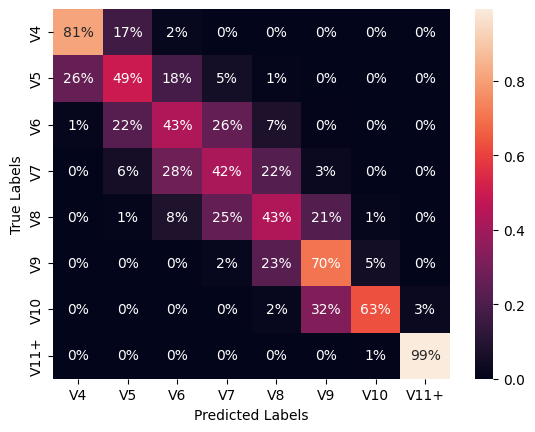

Validation set metrics:


Accuracy: 55.61% | Accuracy +- 1: 91.55%
              precision    recall  f1-score   support

          V4     0.8143    0.8117    0.8130      1556
          V5     0.5438    0.4618    0.4995      1061
          V6     0.3013    0.3423    0.3205       485
          V7     0.2237    0.3118    0.2605       279
          V8     0.4140    0.3495    0.3790       372
          V9     0.2130    0.4000    0.2780        90
         V10     0.3220    0.2262    0.2657        84
        V11+     0.4483    0.3611    0.4000        36

    accuracy                         0.5561      3963
   macro avg     0.4101    0.4080    0.4020      3963
weighted avg     0.5725    0.5561    0.5617      3963



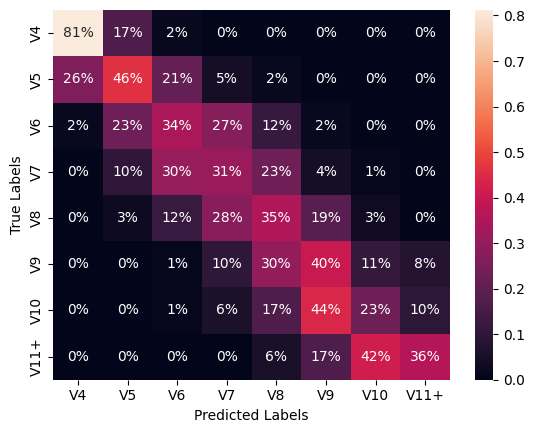

In [21]:
# get metrics
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)

valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(model, valid_cf_iter, device)

In [22]:
# fix the random seed; don't modify this
torch.manual_seed(23459078)

# now try training the CNN model and check the stats
cnn_model = CNN(n_channels, INPUT_DIM // n_channels, OUTPUT_DIM)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)

cnn_model = cnn_model.to(device)
criterion = criterion.to(device)

train_loss_list, valid_loss_list = full_train_valid_loop(cnn_model, 'cnn', train_iterator, valid_iterator, criterion, device, label_smoothing = True)

Number of trainable parameters: 128,919


Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.05274 | Train Acc:  33.20% | Train Acc +/- 1 Grade:  67.63%
	 Val. Loss: 0.03136 |  Val. Acc:  50.38% |  Val. Acc +/- 1 Grade:  85.47%


Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.03881 | Train Acc:  42.14% | Train Acc +/- 1 Grade:  82.53%
	 Val. Loss: 0.02642 |  Val. Acc:  55.22% |  Val. Acc +/- 1 Grade:  91.66%


Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.03460 | Train Acc:  45.15% | Train Acc +/- 1 Grade:  86.64%
	 Val. Loss: 0.02537 |  Val. Acc:  52.76% |  Val. Acc +/- 1 Grade:  91.48%


Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.03249 | Train Acc:  47.65% | Train Acc +/- 1 Grade:  88.55%
	 Val. Loss: 0.02572 |  Val. Acc:  49.79% |  Val. Acc +/- 1 Grade:  90.88%


Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.03127 | Train Acc:  49.21% | Train Acc +/- 1 Grade:  89.92%
	 Val. Loss: 0.02450 |  Val. Acc:  51.24% |  Val. Acc +/- 1 Grade:  91.59%


Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.03026 | Train Acc:  50.37% | Train Acc +/- 1 Grade:  90.39%
	 Val. Loss: 0.02372 |  Val. Acc:  53.16% |  Val. Acc +/- 1 Grade:  92.31%


Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.02972 | Train Acc:  51.10% | Train Acc +/- 1 Grade:  90.96%
	 Val. Loss: 0.02456 |  Val. Acc:  50.37% |  Val. Acc +/- 1 Grade:  91.36%


Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.02938 | Train Acc:  52.38% | Train Acc +/- 1 Grade:  91.32%
	 Val. Loss: 0.02322 |  Val. Acc:  52.79% |  Val. Acc +/- 1 Grade:  92.84%


Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.02884 | Train Acc:  52.42% | Train Acc +/- 1 Grade:  91.82%
	 Val. Loss: 0.02322 |  Val. Acc:  54.18% |  Val. Acc +/- 1 Grade:  92.49%


Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.02869 | Train Acc:  52.79% | Train Acc +/- 1 Grade:  91.95%
	 Val. Loss: 0.02332 |  Val. Acc:  53.07% |  Val. Acc +/- 1 Grade:  92.57%


Epoch: 11 | Epoch Time: 0m 6s
	Train Loss: 0.02812 | Train Acc:  53.36% | Train Acc +/- 1 Grade:  92.44%
	 Val. Loss: 0.02347 |  Val. Acc:  52.30% |  Val. Acc +/- 1 Grade:  93.15%


Epoch: 12 | Epoch Time: 0m 6s
	Train Loss: 0.02788 | Train Acc:  53.52% | Train Acc +/- 1 Grade:  92.34%
	 Val. Loss: 0.02255 |  Val. Acc:  55.13% |  Val. Acc +/- 1 Grade:  93.17%


Epoch: 13 | Epoch Time: 0m 6s
	Train Loss: 0.02780 | Train Acc:  53.88% | Train Acc +/- 1 Grade:  92.80%
	 Val. Loss: 0.02544 |  Val. Acc:  47.70% |  Val. Acc +/- 1 Grade:  91.10%


Epoch: 14 | Epoch Time: 0m 6s
	Train Loss: 0.02728 | Train Acc:  54.98% | Train Acc +/- 1 Grade:  93.11%
	 Val. Loss: 0.02291 |  Val. Acc:  53.89% |  Val. Acc +/- 1 Grade:  92.26%


Epoch: 15 | Epoch Time: 0m 6s
	Train Loss: 0.02742 | Train Acc:  54.98% | Train Acc +/- 1 Grade:  92.89%
	 Val. Loss: 0.02483 |  Val. Acc:  49.36% |  Val. Acc +/- 1 Grade:  91.77%


Epoch: 16 | Epoch Time: 0m 6s
	Train Loss: 0.02695 | Train Acc:  55.26% | Train Acc +/- 1 Grade:  93.64%
	 Val. Loss: 0.02251 |  Val. Acc:  55.88% |  Val. Acc +/- 1 Grade:  92.06%


Epoch: 17 | Epoch Time: 0m 6s
	Train Loss: 0.02690 | Train Acc:  55.55% | Train Acc +/- 1 Grade:  93.52%
	 Val. Loss: 0.02405 |  Val. Acc:  50.72% |  Val. Acc +/- 1 Grade:  91.91%


Epoch: 18 | Epoch Time: 0m 7s
	Train Loss: 0.02665 | Train Acc:  56.02% | Train Acc +/- 1 Grade:  93.66%
	 Val. Loss: 0.02234 |  Val. Acc:  55.17% |  Val. Acc +/- 1 Grade:  92.87%


Epoch: 19 | Epoch Time: 0m 7s
	Train Loss: 0.02678 | Train Acc:  56.02% | Train Acc +/- 1 Grade:  93.40%
	 Val. Loss: 0.02665 |  Val. Acc:  44.89% |  Val. Acc +/- 1 Grade:  89.26%


Epoch: 20 | Epoch Time: 0m 6s
	Train Loss: 0.02671 | Train Acc:  55.73% | Train Acc +/- 1 Grade:  93.78%
	 Val. Loss: 0.02295 |  Val. Acc:  53.71% |  Val. Acc +/- 1 Grade:  92.69%


Epoch: 21 | Epoch Time: 0m 6s
	Train Loss: 0.02631 | Train Acc:  56.89% | Train Acc +/- 1 Grade:  94.11%
	 Val. Loss: 0.02226 |  Val. Acc:  55.38% |  Val. Acc +/- 1 Grade:  93.20%


Epoch: 22 | Epoch Time: 0m 6s
	Train Loss: 0.02655 | Train Acc:  56.22% | Train Acc +/- 1 Grade:  93.91%
	 Val. Loss: 0.02341 |  Val. Acc:  51.65% |  Val. Acc +/- 1 Grade:  92.88%


Epoch: 23 | Epoch Time: 0m 6s
	Train Loss: 0.02606 | Train Acc:  57.00% | Train Acc +/- 1 Grade:  94.12%
	 Val. Loss: 0.02347 |  Val. Acc:  51.85% |  Val. Acc +/- 1 Grade:  92.47%


Epoch: 24 | Epoch Time: 0m 5s
	Train Loss: 0.02617 | Train Acc:  56.98% | Train Acc +/- 1 Grade:  94.13%
	 Val. Loss: 0.02243 |  Val. Acc:  54.75% |  Val. Acc +/- 1 Grade:  93.15%


Epoch: 25 | Epoch Time: 0m 6s
	Train Loss: 0.02598 | Train Acc:  57.52% | Train Acc +/- 1 Grade:  94.18%
	 Val. Loss: 0.02324 |  Val. Acc:  52.50% |  Val. Acc +/- 1 Grade:  93.18%


Epoch: 26 | Epoch Time: 0m 6s
	Train Loss: 0.02590 | Train Acc:  57.44% | Train Acc +/- 1 Grade:  94.51%
	 Val. Loss: 0.02354 |  Val. Acc:  51.45% |  Val. Acc +/- 1 Grade:  92.88%


Epoch: 27 | Epoch Time: 0m 6s
	Train Loss: 0.02576 | Train Acc:  57.61% | Train Acc +/- 1 Grade:  94.48%
	 Val. Loss: 0.02259 |  Val. Acc:  53.44% |  Val. Acc +/- 1 Grade:  93.28%


Epoch: 28 | Epoch Time: 0m 6s
	Train Loss: 0.02591 | Train Acc:  56.86% | Train Acc +/- 1 Grade:  94.30%
	 Val. Loss: 0.02269 |  Val. Acc:  53.44% |  Val. Acc +/- 1 Grade:  93.18%


Epoch: 29 | Epoch Time: 0m 5s
	Train Loss: 0.02574 | Train Acc:  58.39% | Train Acc +/- 1 Grade:  94.49%
	 Val. Loss: 0.02367 |  Val. Acc:  52.30% |  Val. Acc +/- 1 Grade:  92.80%


Epoch: 30 | Epoch Time: 0m 5s
	Train Loss: 0.02580 | Train Acc:  58.02% | Train Acc +/- 1 Grade:  94.27%
	 Val. Loss: 0.02469 |  Val. Acc:  49.94% |  Val. Acc +/- 1 Grade:  91.89%


Epoch: 31 | Epoch Time: 0m 5s
	Train Loss: 0.02555 | Train Acc:  57.88% | Train Acc +/- 1 Grade:  94.83%
	 Val. Loss: 0.02376 |  Val. Acc:  51.80% |  Val. Acc +/- 1 Grade:  91.64%


Epoch: 32 | Epoch Time: 0m 5s
	Train Loss: 0.02570 | Train Acc:  57.64% | Train Acc +/- 1 Grade:  94.35%
	 Val. Loss: 0.02429 |  Val. Acc:  49.08% |  Val. Acc +/- 1 Grade:  92.62%


Epoch: 33 | Epoch Time: 0m 5s
	Train Loss: 0.02539 | Train Acc:  58.44% | Train Acc +/- 1 Grade:  94.80%
	 Val. Loss: 0.02299 |  Val. Acc:  53.07% |  Val. Acc +/- 1 Grade:  92.82%


Epoch: 34 | Epoch Time: 0m 5s
	Train Loss: 0.02576 | Train Acc:  57.81% | Train Acc +/- 1 Grade:  94.57%
	 Val. Loss: 0.02310 |  Val. Acc:  52.76% |  Val. Acc +/- 1 Grade:  93.03%


Epoch: 35 | Epoch Time: 0m 5s
	Train Loss: 0.02547 | Train Acc:  58.02% | Train Acc +/- 1 Grade:  94.73%
	 Val. Loss: 0.02275 |  Val. Acc:  53.80% |  Val. Acc +/- 1 Grade:  93.05%


Epoch: 36 | Epoch Time: 0m 5s
	Train Loss: 0.02521 | Train Acc:  58.53% | Train Acc +/- 1 Grade:  94.66%
	 Val. Loss: 0.02262 |  Val. Acc:  54.07% |  Val. Acc +/- 1 Grade:  92.85%


Epoch: 37 | Epoch Time: 0m 5s
	Train Loss: 0.02521 | Train Acc:  58.36% | Train Acc +/- 1 Grade:  94.88%
	 Val. Loss: 0.02270 |  Val. Acc:  53.47% |  Val. Acc +/- 1 Grade:  93.33%


Epoch: 38 | Epoch Time: 0m 5s
	Train Loss: 0.02537 | Train Acc:  58.50% | Train Acc +/- 1 Grade:  94.67%
	 Val. Loss: 0.02413 |  Val. Acc:  50.94% |  Val. Acc +/- 1 Grade:  91.92%


Epoch: 39 | Epoch Time: 0m 5s
	Train Loss: 0.02559 | Train Acc:  58.24% | Train Acc +/- 1 Grade:  94.58%
	 Val. Loss: 0.02404 |  Val. Acc:  50.27% |  Val. Acc +/- 1 Grade:  91.97%


Epoch: 40 | Epoch Time: 0m 5s
	Train Loss: 0.02514 | Train Acc:  59.16% | Train Acc +/- 1 Grade:  95.22%
	 Val. Loss: 0.02250 |  Val. Acc:  55.35% |  Val. Acc +/- 1 Grade:  93.36%


Epoch: 41 | Epoch Time: 0m 5s
	Train Loss: 0.02508 | Train Acc:  59.25% | Train Acc +/- 1 Grade:  94.94%
	 Val. Loss: 0.02380 |  Val. Acc:  51.34% |  Val. Acc +/- 1 Grade:  92.83%


Epoch: 42 | Epoch Time: 0m 5s
	Train Loss: 0.02509 | Train Acc:  58.55% | Train Acc +/- 1 Grade:  95.00%
	 Val. Loss: 0.02337 |  Val. Acc:  52.93% |  Val. Acc +/- 1 Grade:  93.00%


Epoch: 43 | Epoch Time: 0m 5s
	Train Loss: 0.02526 | Train Acc:  58.39% | Train Acc +/- 1 Grade:  94.66%
	 Val. Loss: 0.02288 |  Val. Acc:  53.49% |  Val. Acc +/- 1 Grade:  92.75%


Epoch: 44 | Epoch Time: 0m 5s
	Train Loss: 0.02494 | Train Acc:  59.32% | Train Acc +/- 1 Grade:  95.22%
	 Val. Loss: 0.02269 |  Val. Acc:  55.30% |  Val. Acc +/- 1 Grade:  92.35%


Epoch: 45 | Epoch Time: 0m 5s
	Train Loss: 0.02489 | Train Acc:  59.18% | Train Acc +/- 1 Grade:  95.30%
	 Val. Loss: 0.02262 |  Val. Acc:  54.95% |  Val. Acc +/- 1 Grade:  93.23%


Epoch: 46 | Epoch Time: 0m 5s
	Train Loss: 0.02532 | Train Acc:  59.06% | Train Acc +/- 1 Grade:  94.65%
	 Val. Loss: 0.02459 |  Val. Acc:  49.53% |  Val. Acc +/- 1 Grade:  91.94%


Epoch: 47 | Epoch Time: 0m 5s
	Train Loss: 0.02524 | Train Acc:  58.44% | Train Acc +/- 1 Grade:  94.87%
	 Val. Loss: 0.02487 |  Val. Acc:  48.45% |  Val. Acc +/- 1 Grade:  92.40%


Epoch: 48 | Epoch Time: 0m 5s
	Train Loss: 0.02489 | Train Acc:  59.48% | Train Acc +/- 1 Grade:  95.24%
	 Val. Loss: 0.02286 |  Val. Acc:  54.54% |  Val. Acc +/- 1 Grade:  92.80%


Epoch: 49 | Epoch Time: 0m 5s
	Train Loss: 0.02491 | Train Acc:  59.50% | Train Acc +/- 1 Grade:  95.07%
	 Val. Loss: 0.02313 |  Val. Acc:  52.20% |  Val. Acc +/- 1 Grade:  92.78%


Epoch: 50 | Epoch Time: 0m 5s
	Train Loss: 0.02510 | Train Acc:  59.09% | Train Acc +/- 1 Grade:  95.05%
	 Val. Loss: 0.02399 |  Val. Acc:  50.74% |  Val. Acc +/- 1 Grade:  93.25%


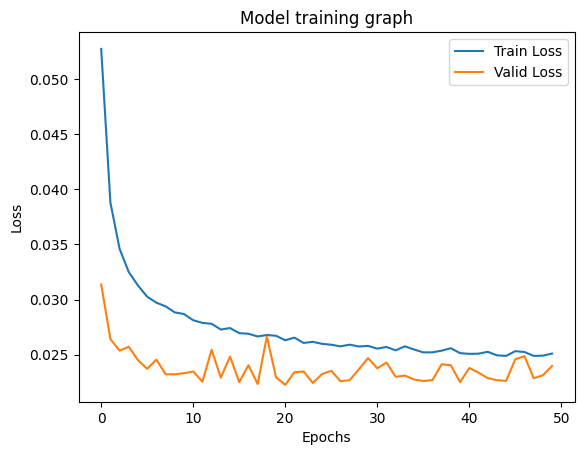

In [23]:
# plot our graph
plot_train_graph(train_loss_list, valid_loss_list)

In [24]:
# get the best performing model weights
cnn_model.load_state_dict(torch.load('cnn.pt'))

# show a boulder
show_boulder(cnn_model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - E - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - M - - - - - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - M - - - - - 
10 | - - - M - - - M - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - M S - - - - 
 5 | - - - - - - - - S - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)
NN Estimation: V5 (6C/+)
Full correct class: [0. 0. 0. 0. 0. 0. 0.]
Model estim. class: [0.6 0.2 0.  0.  0.  0.  0. ]


Training set metrics:


Accuracy: 65.34% | Accuracy +- 1: 97.37%
              precision    recall  f1-score   support

          V4     0.8551    0.7674    0.8089      6229
          V5     0.5770    0.5561    0.5664      4244
          V6     0.4472    0.5869    0.5076      1939
          V7     0.3863    0.5345    0.4485      1115
          V8     0.7376    0.4892    0.5883      1488
          V9     0.5224    0.8111    0.6355       360
         V10     0.8261    0.9585    0.8874       337
        V11+     0.9536    1.0000    0.9763       144

    accuracy                         0.6534     15856
   macro avg     0.6632    0.7130    0.6773     15856
weighted avg     0.6795    0.6534    0.6603     15856



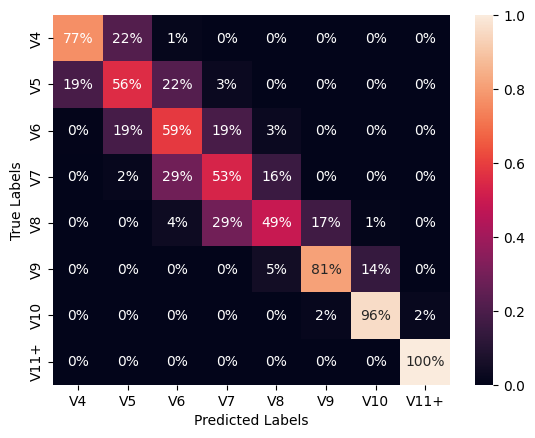

Validation set metrics:


Accuracy: 55.36% | Accuracy +- 1: 93.24%
              precision    recall  f1-score   support

          V4     0.8436    0.7629    0.8012      1556
          V5     0.5241    0.4910    0.5071      1061
          V6     0.3142    0.4289    0.3627       485
          V7     0.2316    0.3262    0.2708       279
          V8     0.4760    0.3199    0.3826       372
          V9     0.2367    0.4444    0.3089        90
         V10     0.3158    0.2857    0.3000        84
        V11+     0.3333    0.1111    0.1667        36

    accuracy                         0.5536      3963
   macro avg     0.4094    0.3963    0.3875      3963
weighted avg     0.5861    0.5536    0.5646      3963



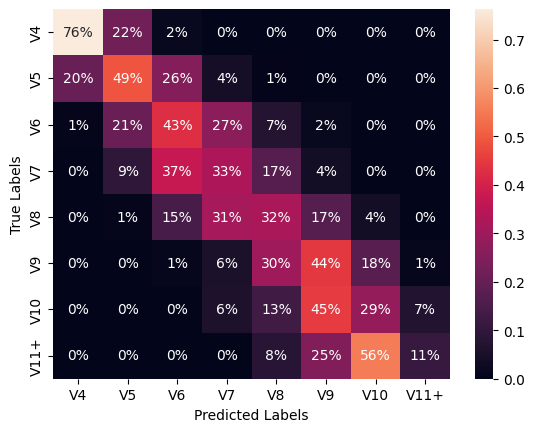

In [25]:
# get model stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)


valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(cnn_model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(cnn_model, valid_cf_iter, device)

In [26]:
# fix the random seed; don't modify this
torch.manual_seed(23459078)

# now try training the ResNet model and check the stats
resnet_model = ResNet(n_channels, INPUT_DIM // n_channels, OUTPUT_DIM)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-3, weight_decay=1e-5)

resnet_model = resnet_model.to(device)
criterion = criterion.to(device)

train_loss_list, valid_loss_list = full_train_valid_loop(resnet_model, 'resnet', train_iterator, valid_iterator, criterion, device, label_smoothing = True)

Number of trainable parameters: 208,583


Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.05807 | Train Acc:  26.82% | Train Acc +/- 1 Grade:  62.17%
	 Val. Loss: 0.02898 |  Val. Acc:  54.01% |  Val. Acc +/- 1 Grade:  86.00%


Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.04245 | Train Acc:  39.04% | Train Acc +/- 1 Grade:  78.12%
	 Val. Loss: 0.02845 |  Val. Acc:  49.83% |  Val. Acc +/- 1 Grade:  85.06%


Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.03665 | Train Acc:  44.11% | Train Acc +/- 1 Grade:  84.52%
	 Val. Loss: 0.02507 |  Val. Acc:  53.97% |  Val. Acc +/- 1 Grade:  88.71%


Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.03400 | Train Acc:  46.84% | Train Acc +/- 1 Grade:  86.42%
	 Val. Loss: 0.02547 |  Val. Acc:  53.49% |  Val. Acc +/- 1 Grade:  88.63%


Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.03134 | Train Acc:  50.60% | Train Acc +/- 1 Grade:  88.40%
	 Val. Loss: 0.02532 |  Val. Acc:  51.94% |  Val. Acc +/- 1 Grade:  89.11%


Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.03044 | Train Acc:  51.89% | Train Acc +/- 1 Grade:  89.48%
	 Val. Loss: 0.02334 |  Val. Acc:  56.74% |  Val. Acc +/- 1 Grade:  90.96%


Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.02874 | Train Acc:  54.40% | Train Acc +/- 1 Grade:  90.46%
	 Val. Loss: 0.02331 |  Val. Acc:  57.22% |  Val. Acc +/- 1 Grade:  91.20%


Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.02834 | Train Acc:  55.20% | Train Acc +/- 1 Grade:  90.76%
	 Val. Loss: 0.02503 |  Val. Acc:  54.44% |  Val. Acc +/- 1 Grade:  91.41%


Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.02749 | Train Acc:  56.29% | Train Acc +/- 1 Grade:  91.40%
	 Val. Loss: 0.02399 |  Val. Acc:  55.33% |  Val. Acc +/- 1 Grade:  90.83%


Epoch: 10 | Epoch Time: 0m 8s
	Train Loss: 0.02727 | Train Acc:  56.69% | Train Acc +/- 1 Grade:  91.62%
	 Val. Loss: 0.02267 |  Val. Acc:  56.98% |  Val. Acc +/- 1 Grade:  92.62%


Epoch: 11 | Epoch Time: 0m 8s
	Train Loss: 0.02651 | Train Acc:  57.71% | Train Acc +/- 1 Grade:  92.05%
	 Val. Loss: 0.02337 |  Val. Acc:  57.89% |  Val. Acc +/- 1 Grade:  91.26%


Epoch: 12 | Epoch Time: 0m 8s
	Train Loss: 0.02621 | Train Acc:  58.25% | Train Acc +/- 1 Grade:  92.46%
	 Val. Loss: 0.02341 |  Val. Acc:  53.52% |  Val. Acc +/- 1 Grade:  92.49%


Epoch: 13 | Epoch Time: 0m 9s
	Train Loss: 0.02571 | Train Acc:  58.99% | Train Acc +/- 1 Grade:  92.87%
	 Val. Loss: 0.02285 |  Val. Acc:  57.27% |  Val. Acc +/- 1 Grade:  91.53%


Epoch: 14 | Epoch Time: 0m 9s
	Train Loss: 0.02532 | Train Acc:  59.59% | Train Acc +/- 1 Grade:  92.96%
	 Val. Loss: 0.02391 |  Val. Acc:  54.81% |  Val. Acc +/- 1 Grade:  90.70%


Epoch: 15 | Epoch Time: 0m 9s
	Train Loss: 0.02499 | Train Acc:  60.27% | Train Acc +/- 1 Grade:  93.30%
	 Val. Loss: 0.02258 |  Val. Acc:  57.41% |  Val. Acc +/- 1 Grade:  92.42%


Epoch: 16 | Epoch Time: 0m 9s
	Train Loss: 0.02488 | Train Acc:  60.03% | Train Acc +/- 1 Grade:  93.10%
	 Val. Loss: 0.02308 |  Val. Acc:  55.99% |  Val. Acc +/- 1 Grade:  91.99%


Epoch: 17 | Epoch Time: 0m 9s
	Train Loss: 0.02455 | Train Acc:  61.16% | Train Acc +/- 1 Grade:  93.58%
	 Val. Loss: 0.02388 |  Val. Acc:  54.02% |  Val. Acc +/- 1 Grade:  91.97%


Epoch: 18 | Epoch Time: 0m 9s
	Train Loss: 0.02406 | Train Acc:  61.51% | Train Acc +/- 1 Grade:  93.60%
	 Val. Loss: 0.02434 |  Val. Acc:  53.24% |  Val. Acc +/- 1 Grade:  92.55%


Epoch: 19 | Epoch Time: 0m 9s
	Train Loss: 0.02363 | Train Acc:  62.32% | Train Acc +/- 1 Grade:  94.24%
	 Val. Loss: 0.02360 |  Val. Acc:  56.29% |  Val. Acc +/- 1 Grade:  92.67%


Epoch: 20 | Epoch Time: 0m 9s
	Train Loss: 0.02360 | Train Acc:  62.38% | Train Acc +/- 1 Grade:  94.31%
	 Val. Loss: 0.02396 |  Val. Acc:  54.43% |  Val. Acc +/- 1 Grade:  92.36%


Epoch: 21 | Epoch Time: 0m 9s
	Train Loss: 0.02332 | Train Acc:  62.62% | Train Acc +/- 1 Grade:  94.36%
	 Val. Loss: 0.02287 |  Val. Acc:  55.48% |  Val. Acc +/- 1 Grade:  93.37%


Epoch: 22 | Epoch Time: 0m 9s
	Train Loss: 0.02321 | Train Acc:  63.21% | Train Acc +/- 1 Grade:  94.56%
	 Val. Loss: 0.02436 |  Val. Acc:  52.76% |  Val. Acc +/- 1 Grade:  92.36%


Epoch: 23 | Epoch Time: 0m 9s
	Train Loss: 0.02337 | Train Acc:  62.88% | Train Acc +/- 1 Grade:  94.23%
	 Val. Loss: 0.02481 |  Val. Acc:  50.44% |  Val. Acc +/- 1 Grade:  92.87%


Epoch: 24 | Epoch Time: 0m 9s
	Train Loss: 0.02351 | Train Acc:  62.81% | Train Acc +/- 1 Grade:  94.17%
	 Val. Loss: 0.02256 |  Val. Acc:  59.86% |  Val. Acc +/- 1 Grade:  92.21%


Epoch: 25 | Epoch Time: 0m 9s
	Train Loss: 0.02277 | Train Acc:  63.20% | Train Acc +/- 1 Grade:  94.74%
	 Val. Loss: 0.02338 |  Val. Acc:  54.49% |  Val. Acc +/- 1 Grade:  92.09%


Epoch: 26 | Epoch Time: 0m 9s
	Train Loss: 0.02275 | Train Acc:  64.11% | Train Acc +/- 1 Grade:  94.57%
	 Val. Loss: 0.02377 |  Val. Acc:  53.65% |  Val. Acc +/- 1 Grade:  92.41%


Epoch: 27 | Epoch Time: 0m 9s
	Train Loss: 0.02237 | Train Acc:  64.63% | Train Acc +/- 1 Grade:  94.80%
	 Val. Loss: 0.02302 |  Val. Acc:  58.18% |  Val. Acc +/- 1 Grade:  92.31%


Epoch: 28 | Epoch Time: 0m 9s
	Train Loss: 0.02271 | Train Acc:  63.54% | Train Acc +/- 1 Grade:  94.60%
	 Val. Loss: 0.02273 |  Val. Acc:  58.31% |  Val. Acc +/- 1 Grade:  92.75%


Epoch: 29 | Epoch Time: 0m 9s
	Train Loss: 0.02258 | Train Acc:  64.39% | Train Acc +/- 1 Grade:  94.46%
	 Val. Loss: 0.02339 |  Val. Acc:  56.28% |  Val. Acc +/- 1 Grade:  92.69%


Epoch: 30 | Epoch Time: 0m 9s
	Train Loss: 0.02221 | Train Acc:  64.85% | Train Acc +/- 1 Grade:  94.85%
	 Val. Loss: 0.02587 |  Val. Acc:  48.90% |  Val. Acc +/- 1 Grade:  92.82%


Epoch: 31 | Epoch Time: 0m 9s
	Train Loss: 0.02238 | Train Acc:  64.26% | Train Acc +/- 1 Grade:  94.97%
	 Val. Loss: 0.02439 |  Val. Acc:  53.60% |  Val. Acc +/- 1 Grade:  92.32%


Epoch: 32 | Epoch Time: 0m 9s
	Train Loss: 0.02195 | Train Acc:  64.80% | Train Acc +/- 1 Grade:  94.97%
	 Val. Loss: 0.02263 |  Val. Acc:  57.17% |  Val. Acc +/- 1 Grade:  92.99%


Epoch: 33 | Epoch Time: 0m 9s
	Train Loss: 0.02213 | Train Acc:  64.60% | Train Acc +/- 1 Grade:  95.01%
	 Val. Loss: 0.02597 |  Val. Acc:  46.26% |  Val. Acc +/- 1 Grade:  92.31%


Epoch: 34 | Epoch Time: 0m 9s
	Train Loss: 0.02191 | Train Acc:  65.57% | Train Acc +/- 1 Grade:  95.02%
	 Val. Loss: 0.02352 |  Val. Acc:  54.97% |  Val. Acc +/- 1 Grade:  92.74%


Epoch: 35 | Epoch Time: 0m 9s
	Train Loss: 0.02192 | Train Acc:  65.09% | Train Acc +/- 1 Grade:  95.16%
	 Val. Loss: 0.02354 |  Val. Acc:  56.07% |  Val. Acc +/- 1 Grade:  90.68%


Epoch: 36 | Epoch Time: 0m 9s
	Train Loss: 0.02138 | Train Acc:  66.25% | Train Acc +/- 1 Grade:  95.31%
	 Val. Loss: 0.02401 |  Val. Acc:  53.80% |  Val. Acc +/- 1 Grade:  92.85%


Epoch: 37 | Epoch Time: 0m 9s
	Train Loss: 0.02184 | Train Acc:  65.54% | Train Acc +/- 1 Grade:  94.96%
	 Val. Loss: 0.02337 |  Val. Acc:  56.54% |  Val. Acc +/- 1 Grade:  92.57%


Epoch: 38 | Epoch Time: 0m 9s
	Train Loss: 0.02161 | Train Acc:  65.48% | Train Acc +/- 1 Grade:  95.18%
	 Val. Loss: 0.02259 |  Val. Acc:  58.43% |  Val. Acc +/- 1 Grade:  92.88%


Epoch: 39 | Epoch Time: 0m 9s
	Train Loss: 0.02146 | Train Acc:  66.04% | Train Acc +/- 1 Grade:  95.41%
	 Val. Loss: 0.02267 |  Val. Acc:  57.17% |  Val. Acc +/- 1 Grade:  93.43%


Epoch: 40 | Epoch Time: 0m 9s
	Train Loss: 0.02101 | Train Acc:  67.47% | Train Acc +/- 1 Grade:  95.60%
	 Val. Loss: 0.02359 |  Val. Acc:  55.10% |  Val. Acc +/- 1 Grade:  92.72%


Epoch: 41 | Epoch Time: 0m 9s
	Train Loss: 0.02155 | Train Acc:  65.94% | Train Acc +/- 1 Grade:  95.34%
	 Val. Loss: 0.02387 |  Val. Acc:  54.14% |  Val. Acc +/- 1 Grade:  92.29%


Epoch: 42 | Epoch Time: 0m 9s
	Train Loss: 0.02127 | Train Acc:  66.57% | Train Acc +/- 1 Grade:  95.19%
	 Val. Loss: 0.02262 |  Val. Acc:  58.00% |  Val. Acc +/- 1 Grade:  93.27%


Epoch: 43 | Epoch Time: 0m 9s
	Train Loss: 0.02091 | Train Acc:  67.06% | Train Acc +/- 1 Grade:  95.40%
	 Val. Loss: 0.02363 |  Val. Acc:  57.68% |  Val. Acc +/- 1 Grade:  92.75%


Epoch: 44 | Epoch Time: 0m 9s
	Train Loss: 0.02114 | Train Acc:  66.65% | Train Acc +/- 1 Grade:  95.43%
	 Val. Loss: 0.02364 |  Val. Acc:  57.06% |  Val. Acc +/- 1 Grade:  92.77%


Epoch: 45 | Epoch Time: 0m 9s
	Train Loss: 0.02074 | Train Acc:  67.65% | Train Acc +/- 1 Grade:  95.50%
	 Val. Loss: 0.02327 |  Val. Acc:  56.79% |  Val. Acc +/- 1 Grade:  92.97%


Epoch: 46 | Epoch Time: 0m 9s
	Train Loss: 0.02096 | Train Acc:  67.10% | Train Acc +/- 1 Grade:  95.59%
	 Val. Loss: 0.02426 |  Val. Acc:  53.26% |  Val. Acc +/- 1 Grade:  92.45%


Epoch: 47 | Epoch Time: 0m 9s
	Train Loss: 0.02058 | Train Acc:  67.83% | Train Acc +/- 1 Grade:  95.65%
	 Val. Loss: 0.02295 |  Val. Acc:  57.42% |  Val. Acc +/- 1 Grade:  93.45%


Epoch: 48 | Epoch Time: 0m 9s
	Train Loss: 0.02108 | Train Acc:  66.90% | Train Acc +/- 1 Grade:  95.09%
	 Val. Loss: 0.02302 |  Val. Acc:  57.44% |  Val. Acc +/- 1 Grade:  93.02%


Epoch: 49 | Epoch Time: 0m 9s
	Train Loss: 0.02135 | Train Acc:  67.16% | Train Acc +/- 1 Grade:  95.59%
	 Val. Loss: 0.02315 |  Val. Acc:  57.92% |  Val. Acc +/- 1 Grade:  93.15%


Epoch: 50 | Epoch Time: 0m 9s
	Train Loss: 0.02087 | Train Acc:  67.04% | Train Acc +/- 1 Grade:  95.76%
	 Val. Loss: 0.02269 |  Val. Acc:  57.90% |  Val. Acc +/- 1 Grade:  93.17%


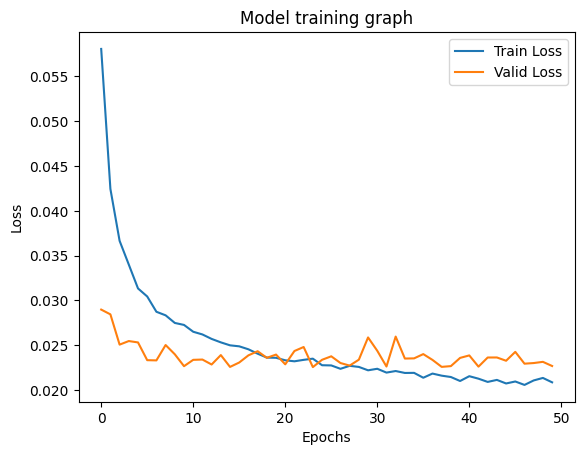

In [27]:
# plot our graph
plot_train_graph(train_loss_list, valid_loss_list)

In [28]:
# get the best performing model weights
resnet_model.load_state_dict(torch.load('resnet.pt'))

# show a boulder
show_boulder(resnet_model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - - - - - E - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - - - M - - - - 
14 | - - - - - - - - M - - 
13 | - - - - - - - - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - M - - - 
 9 | - - - - - - - - - - M 
 8 | - - - - - - - - - M - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - - - - - S S 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)
NN Estimation: V4 (6B+)
Full correct class: [0. 0. 0. 0. 0. 0. 0.]
Model estim. class: [0.1 0.  0.  0.  0.  0.  0. ]


Training set metrics:


Accuracy: 67.80% | Accuracy +- 1: 97.48%
              precision    recall  f1-score   support

          V4     0.7901    0.8782    0.8318      6229
          V5     0.5921    0.5429    0.5664      4244
          V6     0.4531    0.3889    0.4185      1939
          V7     0.3745    0.4897    0.4244      1115
          V8     0.8356    0.5773    0.6828      1488
          V9     0.8297    0.9472    0.8846       360
         V10     0.9940    0.9852    0.9896       337
        V11+     0.9796    1.0000    0.9897       144

    accuracy                         0.6780     15856
   macro avg     0.7311    0.7262    0.7235     15856
weighted avg     0.6779    0.6780    0.6736     15856



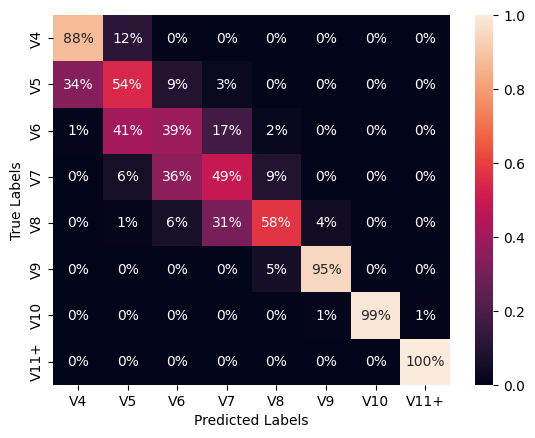

Validation set metrics:


Accuracy: 59.85% | Accuracy +- 1: 92.20%
              precision    recall  f1-score   support

          V4     0.7894    0.8766    0.8307      1556
          V5     0.5579    0.5269    0.5419      1061
          V6     0.4010    0.3340    0.3645       485
          V7     0.2321    0.2903    0.2580       279
          V8     0.4916    0.3952    0.4382       372
          V9     0.3084    0.3667    0.3350        90
         V10     0.2745    0.1667    0.2074        84
        V11+     0.5217    0.3333    0.4068        36

    accuracy                         0.5985      3963
   macro avg     0.4471    0.4112    0.4228      3963
weighted avg     0.5884    0.5985    0.5908      3963



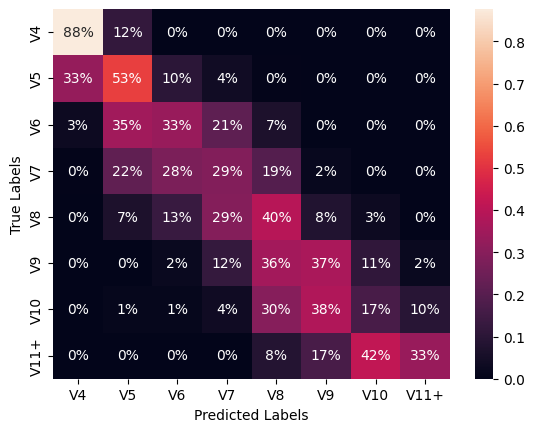

In [29]:
# get model stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)


valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(resnet_model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(resnet_model, valid_cf_iter, device)

In [30]:
# save using onnx runtime for inference (only available for MLP since the CNN and the ResNet both use adaptive Max-Pooling)
view_iterator = data.DataLoader(dataset,
                                     shuffle=True,
                                     batch_size=1)

board, grade = next(iter(view_iterator))
model = model.to(device)
board = board.to(device)
torch.onnx.export(model,                     # model being run
                  board,                     # model input (or a tuple for multiple inputs)
                  "moonboard_clf-mlp.onnx",  # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                            # the ONNX version to export the model to
                    # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [31]:
# save the other models for inference
torch.save(cnn_model, 'moonboard-clf-cnn.pth')
torch.save(resnet_model, 'moonboard-clf-resnet.pth')